# Flora Model Development

This notebook contains the code that is used to develop the final version of Flora, which is integrated into the PyQT6 Application - SafePlant+.

**Data Processing**
- The past 12 versions of Flora Development have lead to the model not performing well on the application despite performing well in the notebook. We then decided to change datasets and downloaded a new one from Kaggle, titles "New Plant Disease Dataset" which contained 87K images. 
- We shortened it down to 12 classes with the most number of images. The images in each class were also similar in number and were around 2-2.4K images, reducing the need for Data Augmentation as we thought 2K for each class is good enough.
- We wanted the model to split the set into train, test and validation split, and as a result we combined all the classes and then fed it into Tensorflow image_from_directory function which then split it for us. 

**Model Training**
- We implemented **Transfer Learning** using the MobileNetV2 and MobileNetV3 models and performed a comparison between the performance of these two models.
- We froze the final 50 & unfroze the final 50 layers of the model during the first and the second loop respectively. 
- We used either MobileNetV2 or MobileNetV3 as the backbone as the feature extractor and coded our own classification layers.
- Classifying layers for Flora built on V2 was rudimentary, consisting of simple Dense Layers followed by a Dropout layer. While it did perform well on the validation set and training set in the notebook, it's real world accuracy stemmed down when integrated into the application, causing us to rethink about how to structure our CNN architecture. 
- We designed a better architecture for the classification layers of Flora V13, built on top of MobileNetV3. 
- We did research on the most optimal architecture for Flora, which led us to discovering **Swish activation function**, an improvement over the default ReLu activation function in most deep neural network.
- Our research also led us to trying out a combined pool, fusing both Gap Average Pooling and Global Max Pooling.

**Final Results**
- We trained Flora (the model) for 20 epochs, and the results are immensely positive, showing signs of a model which is generalising well to unseen data and hitting all the correct predicitions with minimal to none misclassifications when we printed out the classification report and the confusion matrix. 
- The real test was when the model was deployed into SafePlant+, where it was able to detect random images from each trained class with almost a 100% confidence score. 
- We tested Flora on random images from the net, it was still able to predict those classes accurately, with a moderate confidence score to a relatively high confidence score. 



## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter


dataset_path = "/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV12/new_dataset" 

# Get the list of class names (subdirectories)
num_classes = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_classes[class_name] = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(num_classes.keys(), num_classes.values(), color='green')
plt.xlabel("Plant Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Plant Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Getting basic details of the dataset

In [ ]:
for class_name, count in num_classes.items():
    print(f"{class_name}: {count} images")

#for loop to get the numnber of class name and the number of images in the class, iterating over each class. 

In [ ]:
#simple for loop to sort the number of classes by the smallest number of images to the max. 
ascending = dict(sorted(num_classes.items(), key=lambda item: item[1], reverse=True))
for class_name, count in ascending.items():
    print(f"{class_name}: {count} images")

In [ ]:
# simple for loop to sort the number of classes by the largest number of images for each class. 

descending = dict(sorted(num_classes.items(), key=lambda item: item[1], reverse=True))


top_13_classes = list(descending.items())[:13]
for class_name, count in top_13_classes:
    print(f"{class_name}: {count} images")

In [ ]:
#filtering the descending list by the top 13 classes with the most number of images. 

descending = dict(sorted(num_classes.items(), key=lambda item: item[1], reverse=True))


top_13_classes = list(descending.items())[:13]


#filtered out one class as images were not consistent 
excluded_classes = {"Corn_(maize)___Common_rust_"}  


filtered_classes = [(class_name, count) for class_name, count in top_13_classes if class_name not in excluded_classes]


for class_name, count in filtered_classes:
    print(f"{class_name}")

In [ ]:
#code to put all filtered classes into a new subfolder used for testing

import os
import shutil


source_dir = "/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV12/new_dataset"


destination_dir = "/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/V13_Dataset"


os.makedirs(destination_dir, exist_ok=True)

# List of top 13 classes
top_13_classes = [
    "Tomato___Early_blight",
    "Grape___Esca_(Black_Measles)",
    "Pepper,_bell___Bacterial_spot",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Grape___Black_rot",
    "Tomato___Leaf_Mold",
    "Corn_(maize)___healthy",
    "Tomato___Late_blight",
    "Peach___Bacterial_spot",
    "Tomato___Target_Spot",
    "Cherry_(including_sour)___healthy",
    "Strawberry___healthy"
]  


for class_name in top_13_classes:
    class_source_path = os.path.join(source_dir, class_name)
    class_dest_path = os.path.join(destination_dir, class_name)

    if os.path.exists(class_source_path) and os.path.isdir(class_source_path):
        os.makedirs(class_dest_path, exist_ok=True)  
        for file_name in os.listdir(class_source_path):
            source_file = os.path.join(class_source_path, file_name)
            if os.path.isfile(source_file):
                shutil.copy(source_file, os.path.join(class_dest_path, file_name))
                print(f"Copied {source_file} to {class_dest_path}")

print("All top 13 class images have been moved successfully!")

### Using Tensorflow to split data into train test val 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img


data_dir = "/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/V13_Dataset"  
output_dir = "/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/TF_Datasets"

batch_size = 32
img_height = 224
img_width = 224
seed = 123

train_dir = os.path.join(output_dir, "Train")
val_dir = os.path.join(output_dir, "Val")
test_dir = os.path.join(output_dir, "Test")


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    label_mode="categorical"
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)


val_test_ds = val_test_ds.unbatch()
val_test_ds = val_test_ds.shuffle(1000, seed=seed)

val_test_count = sum(1 for _ in val_test_ds)
val_count = test_count = val_test_count // 2 #splits validation into 2 

val_ds = val_test_ds.take(val_count).batch(batch_size)
test_ds = val_test_ds.skip(val_count).batch(batch_size)




Found 28069 files belonging to 12 classes.
Using 22456 files for training.
Found 28069 files belonging to 12 classes.
Using 5613 files for validation.


2025-02-08 16:48:49.334133: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:

def save_dataset(dataset, dest_dir, dataset_type, class_names):
    """
    Saves images from a tf.data.Dataset into destination folder,
    naming each file as:
        <dataset_type>_batch<batch_index>_img<image_index>_<class_name>.jpg
    e.g. train_batch0_img0_tomato_blight.jpg
    """
    for batch_idx, (images, labels) in enumerate(dataset):
        for i in range(len(images)):
            # Determine class name from one-hot label
            class_label = class_names[tf.argmax(labels[i]).numpy()]

            # Create the subfolder for this class
            class_folder = os.path.join(dest_dir, class_label)
            os.makedirs(class_folder, exist_ok=True)

            # Convert the image tensor to a PIL Image
            image = array_to_img(images[i])

            # Create a descriptive filename
            filename = f"{dataset_type}_batch{batch_idx}_img{i}_{class_label}.jpg"
            image_path = os.path.join(class_folder, filename)

            # Save the image
            image.save(image_path)

save_dataset(train_ds, train_dir, "train", class_names)
save_dataset(val_ds, val_dir, "val", class_names)
save_dataset(test_ds, test_dir, "test", class_names)

print("Dataset successfully split")

In [13]:
print(f"Total images in val_test_ds: {val_test_count}")
print(f"Validation set count: {val_count}")
print(f"Test set count: {test_count}")

Total images in val_test_ds: 5613
Validation set count: 2806
Test set count: 2806


In [ ]:
# Used autotune to prefetch, allowing for the next batch of data to be loaded into memory while the current batch is being processed, helpign to reduce the time spent waiting for the data to be loaded, leading to faster inference timings while training the model. 

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

### Designing Flora's architecture

Wanting to improve from FloraV12 we did additional research on how we can optimise a model and allow it to bring better performance. 
This is what we got from our research and implemented:

1. Usage of **Swish** Activation function instead of ReLu:
- Swish is a new activation function that has been shown to outperform ReLU in many scenarios, mainly due to it's curve when x is a negative value, unlike ReLu which is a straight line lying on the x axis. This means that ReLu sieves out negative values and does not take it into account, however, due to the curve in Swish's Activation Function, it solves the Dying ReLu problem as it takes into account the non-negative values, which might hold important information for the development of the Model.

2. Combined Global Average Pooling and Global Max Pooling into one single pooling layer:
- Global Average Pooling takes into account the entire context of the feature map, whereas Global Max Pooling takes into account the distinctive features of the feature map. Fusing both Global Average Pooling and Global Max pooling makes sure that the overall context and also the most discriminative informations are being included, leading to an improved model performance. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small  
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Dropout, BatchNormalization, Activation, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV3Small(weights='imagenet', include_top=False)

# for the first loop, we froze the final 50 layers of the model, where the weights wont' get updated. 
# we then unforze those layers for the second loop, where the weights will get updated this time. 
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


gap = GlobalAveragePooling2D()(base_model.output)
gmp = GlobalMaxPooling2D()(base_model.output)
combined_pool = Concatenate()([gap, gmp])
combined_pool = BatchNormalization()(combined_pool) # concatenated two pools together 


x = Dense(512, kernel_regularizer=l2(0.001))(combined_pool)
x = Activation('swish')(x) # switched from ReLu to swish
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)


preds = Dense(12, activation='softmax')(x) # output layer predicting 12 classes with softmax function. 


florav13 = Model(inputs=base_model.input, outputs=preds) # building flora based on MobileNetV3

florav13.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

florav13.summary()

/Users/saikeerthan/NYP-AI/Computer_Vision/cv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling[0][0]   │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, None,      │          0 │ re_lu[0][0],      │
│ (Multiply)          │ None, 16)         │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ expanded_conv_sq

 Total params: 1,703,420 (6.50 MB)

 Trainable params: 1,496,788 (5.71 MB)

 Non-trainable params: 206,632 (807.16 KB)

Implemented Early Stopping and Model Checkpoints to save the best epoch provided by the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

epochs = 20
optimizer = Adam(learning_rate = 0.0001)


check_point = ModelCheckpoint(filepath='/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/model_files/flora-{epoch:02d}-{val_categorical_accuracy:.2f}.h5',monitor="val_categorical_accuracy", mode="max", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    mode='auto',
    restore_best_weights=False,
    start_from_epoch=0
) # track best version of model by it's loss on the validation set. 


florav13.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
history = florav13.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, check_point])

Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_accuracy: 0.6140 - loss: 2.4609

2025-02-08 17:08:16.968105: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/saikeerthan/NYP-AI/Computer_Vision/cv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


702/702 ━━━━━━━━━━━━━━━━━━━━ 107s 147ms/step - categorical_accuracy: 0.6142 - loss: 2.4601 - val_categorical_accuracy: 0.8917 - val_loss: 1.5256
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - categorical_accuracy: 0.9499 - loss: 1.3465

702/702 ━━━━━━━━━━━━━━━━━━━━ 106s 151ms/step - categorical_accuracy: 0.9499 - loss: 1.3464 - val_categorical_accuracy: 0.9690 - val_loss: 1.2139
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9751 - loss: 1.1912

702/702 ━━━━━━━━━━━━━━━━━━━━ 110s 156ms/step - categorical_accuracy: 0.9752 - loss: 1.1911 - val_categorical_accuracy: 0.9904 - val_loss: 1.0717
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - categorical_accuracy: 0.9832 - loss: 1.0738

702/702 ━━━━━━━━━━━━━━━━━━━━ 121s 172ms/step - categorical_accuracy: 0.9832 - loss: 1.0738 - val_categorical_accuracy: 0.9957 - val_loss: 0.9520
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_accuracy: 0.9901 - loss: 0.9447

702/702 ━━━━━━━━━━━━━━━━━━━━ 118s 169ms/step - categorical_accuracy: 0.9901 - loss: 0.9446 - val_categorical_accuracy: 0.9968 - val_loss: 0.8360
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 112s 160ms/step - categorical_accuracy: 0.9929 - loss: 0.8215 - val_categorical_accuracy: 0.9950 - val_loss: 0.7217
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 113s 162ms/step - categorical_accuracy: 0.9946 - loss: 0.6977 - val_categorical_accuracy: 0.9957 - val_loss: 0.5990
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_accuracy: 0.9954 - loss: 0.5792

702/702 ━━━━━━━━━━━━━━━━━━━━ 109s 155ms/step - categorical_accuracy: 0.9954 - loss: 0.5791 - val_categorical_accuracy: 0.9986 - val_loss: 0.4883
Epoch 9/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 110s 157ms/step - categorical_accuracy: 0.9950 - loss: 0.4753 - val_categorical_accuracy: 0.9971 - val_loss: 0.3997
Epoch 10/20


2025-02-08 17:23:17.202027: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


702/702 ━━━━━━━━━━━━━━━━━━━━ 113s 160ms/step - categorical_accuracy: 0.9950 - loss: 0.3873 - val_categorical_accuracy: 0.9986 - val_loss: 0.3242
Epoch 11/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 115s 163ms/step - categorical_accuracy: 0.9969 - loss: 0.3144 - val_categorical_accuracy: 0.9986 - val_loss: 0.2649
Epoch 12/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - categorical_accuracy: 0.9977 - loss: 0.2538

702/702 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - categorical_accuracy: 0.9977 - loss: 0.2538 - val_categorical_accuracy: 0.9989 - val_loss: 0.2126
Epoch 13/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 117s 167ms/step - categorical_accuracy: 0.9978 - loss: 0.2050 - val_categorical_accuracy: 0.9989 - val_loss: 0.1741
Epoch 14/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 117s 166ms/step - categorical_accuracy: 0.9983 - loss: 0.1680 - val_categorical_accuracy: 0.9982 - val_loss: 0.1432
Epoch 15/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 114s 163ms/step - categorical_accuracy: 0.9981 - loss: 0.1384 - val_categorical_accuracy: 0.9964 - val_loss: 0.1252
Epoch 16/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 115s 164ms/step - categorical_accuracy: 0.9969 - loss: 0.1219 - val_categorical_accuracy: 0.9982 - val_loss: 0.1045
Epoch 17/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - categorical_accuracy: 0.9964 - loss: 0.1075 - val_categorical_accuracy: 0.9986 - val_loss: 0.0899
Epoch 18/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 118s 169ms/step - categorical

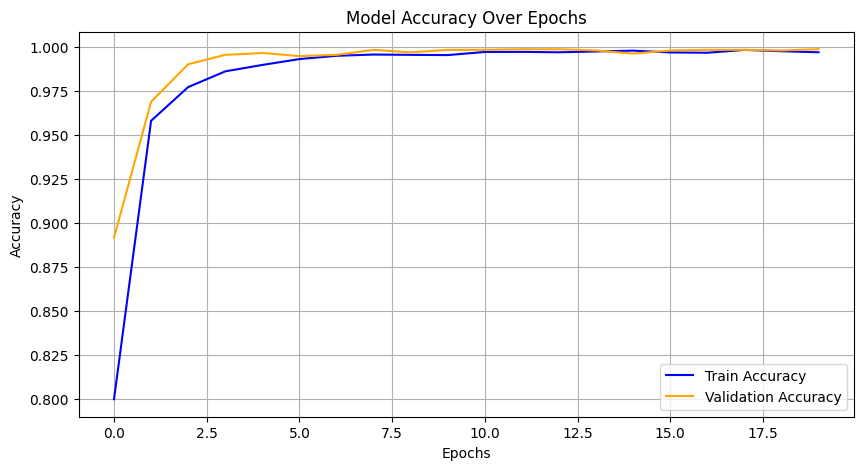

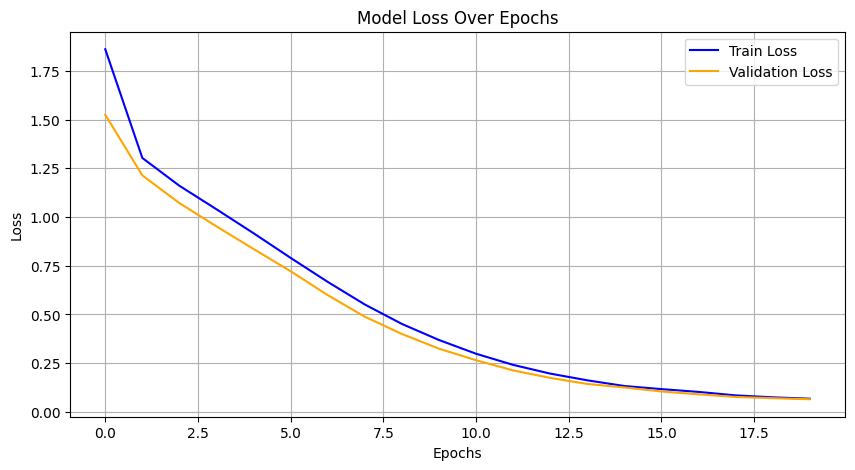

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history["categorical_accuracy"], label="Train Accuracy", color='blue')
plt.plot(history.history["val_categorical_accuracy"], label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss", color='blue')
plt.plot(history.history["val_loss"], label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.grid(True)
plt.show()

**Accuracy:**
1. Shows the Accuracy of the model, with both curves almost approaching 100% accuracy.
2. The graph shows us that the model is fitting well and is learning is improving with every epoch, generalising well to unseen data. 
3. Minimal gap in between training and validation indicating low overfitting

**Loss:**
1. Shows the Loss of the model decreasing steadily during training. 
2. This shows that the model is learning and fitting the data well.
3. The Model has hit its optimal performance as we see the two lines starting to flatten out.


In [18]:
florav13.save('/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/florav13.keras')

In [19]:
import json
with open('/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/train_history.json', 'w') as file_pi:
    json.dump(history.history, file_pi)

In [20]:
str(history.history)

"{'categorical_accuracy': [0.7996971607208252, 0.9581848978996277, 0.9773780107498169, 0.9863288402557373, 0.9899803996086121, 0.9933202862739563, 0.9951906204223633, 0.9959030747413635, 0.9957249760627747, 0.995591402053833, 0.9973726272583008, 0.997417151927948, 0.9971945285797119, 0.9976398348808289, 0.998129665851593, 0.9971054792404175, 0.9969273209571838, 0.9985304474830627, 0.9977734088897705, 0.9971945285797119], 'loss': [1.861667275428772, 1.3034387826919556, 1.1605027914047241, 1.0398913621902466, 0.9169086217880249, 0.7902149558067322, 0.6671029925346375, 0.551051139831543, 0.4512130916118622, 0.3687762916088104, 0.2982029616832733, 0.24104686081409454, 0.1961757093667984, 0.1617443859577179, 0.13251031935214996, 0.11661405116319656, 0.10229697823524475, 0.08438940346240997, 0.0744277611374855, 0.0674605667591095], 'val_categorical_accuracy': [0.891660749912262, 0.9689950346946716, 0.9903777837753296, 0.9957234263420105, 0.9967926144599915, 0.9950106739997864, 0.995723426342

In [21]:
# test acc and test loss 
test_loss_final, test_acc_final= florav13.evaluate(test_ds)
print(f"Final Test loss: {test_loss_final:.3f}")
print(f"Final Test accuracy: {test_acc_final:.3f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - categorical_accuracy: 0.9999 - loss: 0.0573
Final Test loss: 0.059
Final Test accuracy: 0.999


/Users/saikeerthan/NYP-AI/Computer_Vision/cv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Above shows the final test accuracy, boasting an impressive 99% accuracy on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━

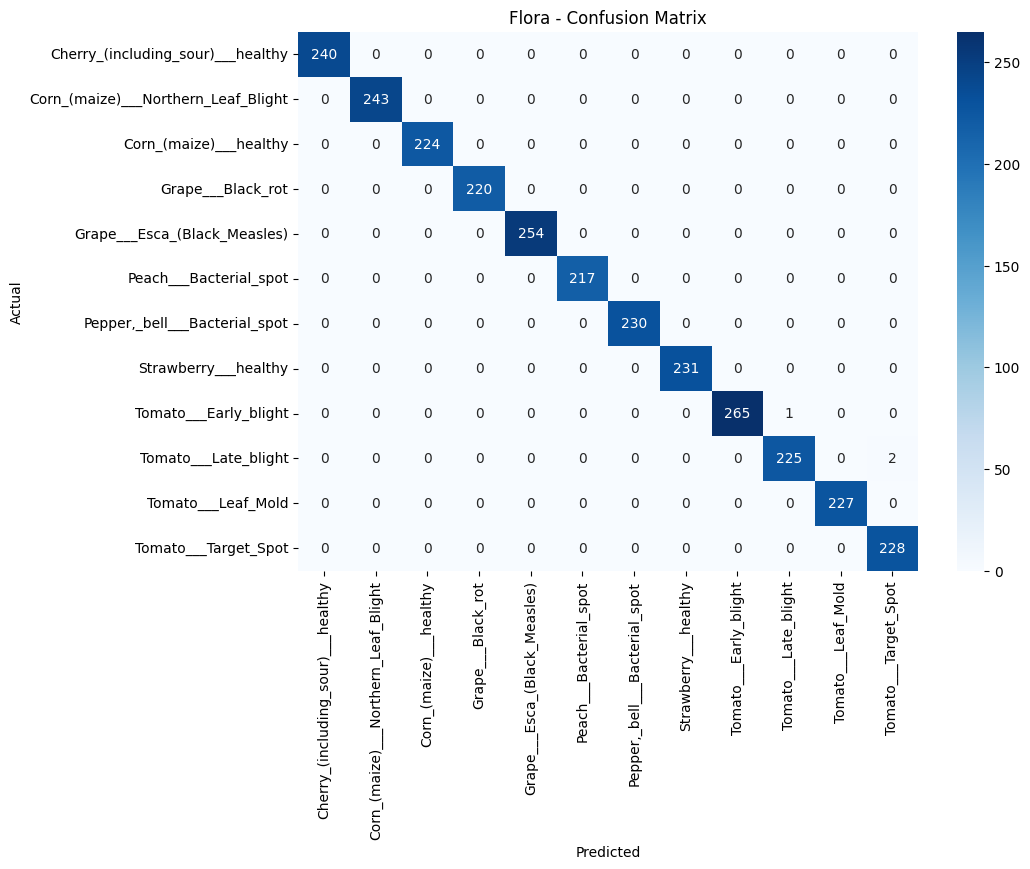

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_gt = []
y_predictions = []

for images, labels in test_dataset:
    predictions = florav13.predict(images)
    y_gt.extend(np.argmax(labels.numpy(), axis=1))
    y_predictions.extend(np.argmax(predictions, axis=1))

matrix = confusion_matrix(y_true=y_gt, y_pred=y_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Flora - Confusion Matrix")
plt.show()

In [46]:
cr = classification_report(y_true=y_gt, y_pred=y_predictions, target_names=class_names, digits=4)
print(cr)

                                     precision    recall  f1-score   support

  Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000       240
Corn_(maize)___Northern_Leaf_Blight     1.0000    1.0000    1.0000       243
             Corn_(maize)___healthy     1.0000    1.0000    1.0000       224
                  Grape___Black_rot     1.0000    1.0000    1.0000       220
       Grape___Esca_(Black_Measles)     1.0000    1.0000    1.0000       254
             Peach___Bacterial_spot     1.0000    1.0000    1.0000       217
      Pepper,_bell___Bacterial_spot     1.0000    1.0000    1.0000       230
               Strawberry___healthy     1.0000    1.0000    1.0000       231
              Tomato___Early_blight     1.0000    0.9962    0.9981       266
               Tomato___Late_blight     0.9956    0.9912    0.9934       227
                 Tomato___Leaf_Mold     1.0000    1.0000    1.0000       227
               Tomato___Target_Spot     0.9913    1.0000    0.9956       22

The Above two cells are the confusion matrix and the classification report. 

**Confusion Matrix**
- This shows how well the model is predicting across every class and we can see that the model is performing well, predicting every class almost correctly with very few misclassifications. 

**Classification Report**:
- This shows the precision, recall, f1 score and support for each class. We can see that the f1 score is 100% for almost every class, where it falters just a bit in "Tomato Early Blight, Tomato Late Blight and Tomato Target Spot. 

The classification report and the confusion matrix shows the impressive model performance, leading to the conclusion that it is generalising well on unseen data and might even predict correctly for images outside of the overall set. 

## 12th Epoch of FloraV13:

We wanted to see if the 12th epoch of Flora would be an improvement, but it showed little to no improvement over the overall final model, so we stuck and implemented the final model into the application

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small  
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Dropout, BatchNormalization, Activation, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV3Small(weights='imagenet', include_top=False)

for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


gap = GlobalAveragePooling2D()(base_model.output)
gmp = GlobalMaxPooling2D()(base_model.output)
combined_pool = Concatenate()([gap, gmp])
combined_pool = BatchNormalization()(combined_pool)


x = Dense(512, kernel_regularizer=l2(0.001))(combined_pool)
x = Activation('swish')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, kernel_regularizer=l2(0.001))(x)
x = Activation('swish')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)


preds = Dense(12, activation='softmax')(x)


florav13_epoch12 = Model(inputs=base_model.input, outputs=preds)
florav13_epoch12.summary()

# #florav13.compile(
#     optimizer=Adam(learning_rate=0.0005),
#     loss='categorical_crossentropy',
#     metrics=['categorical_accuracy']
# )

# florav13.summary()

/Users/saikeerthan/NYP-AI/Computer_Vision/cv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling_2[0][0] │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ activation_42[0]… │
│ (ZeroPadding2D)     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_28[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │          0 │ re_lu_29[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, None,      │          0 │ re_lu_28[0][0],   │
│ (Multiply)          │ None, 16)         │            │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,703,420 (6.50 MB)

 Trainable params: 1,496,788 (5.71 MB)

 Non-trainable params: 206,632 (807.16 KB)

In [41]:
#loaded the model with weights at epoch 12
florav13_epoch12.load_weights(filepath='/Users/saikeerthan/NYP-AI/Computer_Vision/Project/Flora_Development/FloraV13/model_files/flora-12-1.00.h5')

florav13_epoch12.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

test_loss_epoch12, test_acc_epoch12= florav13_epoch12.evaluate(test_ds)
print(f"Final Test loss: {test_loss_epoch12:.3f}")
print(f"Final Test accuracy: {test_acc_epoch12:.3f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - categorical_accuracy: 0.9988 - loss: 0.2101
Final Test loss: 0.211
Final Test accuracy: 0.999


/Users/saikeerthan/NYP-AI/Computer_Vision/cv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [44]:
train_ds.class_names

label_names = train_ds.class_names

label_names

['Cherry_(including_sour)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Peach___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Strawberry___healthy',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Target_Spot']